# パッケージを導入します。

In [1]:
import os
import cv2
import tensorrt as trt
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import matplotlib.pyplot as plt

# ONNXモデルを導入し、TensorRTに変換するための関数定義

In [2]:
def load_onnx_model(onnx_file_path):
    # 创建TensorRT Logger
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    
    # 创建Builder, Network, and Parser
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)

    # 读取ONNX模型
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print("Failed to parse the ONNX file")
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None

    # 编译TensorRT引擎
    config = builder.create_builder_config()
    config.max_workspace_size = 1 << 30  # 1GB
    engine = builder.build_engine(network, config)

    return engine

def allocate_buffers(engine):
    # 计算需要的输入输出缓冲区大小
    h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
    h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    stream = cuda.Stream()

    return h_input, d_input, h_output, d_output, stream

# モデルの導入

In [3]:
# BASE_DIR
BASE_DIR = '/home/vipuser/Projects/TechniqueNota/resources'
ONNX_MODEL = os.path.join(BASE_DIR, 'models/onnx/yolov8n.onnx')

# 加载ONNX并编译成TensorRT引擎
engine = load_onnx_model(ONNX_MODEL)
if engine is None:
    exit(1)

# Print out the debug message
print("The onnx model converted to TensorRT format")

[08/31/2024-20:46:05] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.


/tmp/ipykernel_155570/2573575846.py:20: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 1 << 30  # 1GB
/tmp/ipykernel_155570/2573575846.py:21: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


The onnx model converted to TensorRT format


# 画像を前処理して、推論前にTensorRTモデルに適した形式に変換するため関数定義

In [4]:
def preprocess(image):
    # Resize the input image to 640x640
    resized_img = cv2.resize(image, (640, 640)).astype(np.float32)
    
    # Convert image from BGR to RGB
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Normalize
    resized_img = rgb_img / 255.0

    # Convert the image to the target 
    preprocessed_img = resized_img.transpose(2, 0, 1).ravel() # Return a contiguous flattened array.

    return preprocessed_img

def do_inference(engine, h_input, d_input, h_output, d_output, stream):
    context = engine.create_execution_context()

    # 将输入数据复制到GPU
    cuda.memcpy_htod_async(d_input, h_input, stream)

    # 执行推理
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)

    # 将结果从GPU复制回主机
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()

    return h_output

# 画像の前処理と推論

In [5]:
IMAGE_PATH = os.path.join(BASE_DIR, 'imgs/human_and_pets2.png') 

# Load an image
image = cv2.imread(IMAGE_PATH)

# 分配缓冲区
h_input, d_input, h_output, d_output, stream = allocate_buffers(engine)

# 将图像预处理并复制到输入缓冲区
np.copyto(h_input, preprocess(image))
print(f"The input size is {h_input.shape}")

# 执行推理
output_data = do_inference(engine, h_input, d_input, h_output, d_output, stream)
print(f"The output size is {output_data.shape}")

The input size is (1228800,)
The output size is (705600,)


/tmp/ipykernel_155570/2573575846.py:27: DeprecationWarning: Use get_tensor_shape instead.
  h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
/tmp/ipykernel_155570/2573575846.py:28: DeprecationWarning: Use get_tensor_shape instead.
  h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)


# 推論の後処理

In [6]:
def postprocess(outputs):
    boxes = []
    confidences = []
    class_ids = []

    outputs = outputs.reshape(84, 8400)
    for detection in outputs.T:  # Transpose to iterate over detections
        class_scores = detection[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        if confidence > 0.3:
            cx, cy, w, h = detection[:4]
            box = np.array([cx - w / 2, cy - h / 2, cx + w / 2,  cy + h / 2])
            box = box.astype("int")
            boxes.append(box)
            confidences.append(float(confidence))
            class_ids.append(class_id)

    return boxes, confidences, class_ids

# 結果と出力

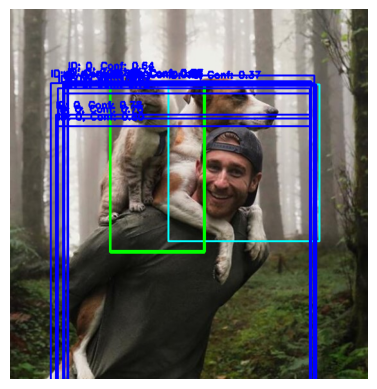

In [7]:
# Process the outputs
boxes, confidences, class_ids = postprocess(output_data)

# Draw the bounding boxes on the image
for box, confidence, class_id in zip(boxes, confidences, class_ids):
    if class_id == 0:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    if class_id == 15:  # COCO cat
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    if class_id == 16:  # COCO dog
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

    if class_id == 0 or class_id == 15 or class_id == 16: 
        label = f'ID: {class_id}, Conf: {confidence:.2f}'
        cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()